In [18]:
%matplotlib inline
import numpy as np
import math, random
import matplotlib.pyplot as plt
import copy
from scipy.stats import norm


class Particle:
    def __init__(self, pose, weight):
        self.pose = np.array(pose)
        self.weight = weight

    def __repr__(self):
        return "pose: " + str(self.pose) + ", weight: " + str(self.weight)

def transition_state(x_old, u):
    # 実際に前進する距離と回転する角度
    forward_distance = random.gauss(u[0], u[0] / 10)
    rotation_angle = random.gauss(u[1], u[1] / 10)
    # 前進する際にズレる角度
    direction_error = random.gauss(0.0, math.pi / 180 * 3.0)

    # 新しい状態を計算
    x = x_old[0] + forward_distance * math.cos(x_old[2] + direction_error)
    y = x_old[1] + forward_distance * math.sin(x_old[2] + direction_error)
    theta = x_old[2] + rotation_angle

    return np.array([x, y, theta])

def relative_landmark_pos(pos, landmark):
    x, y, theta = pos
    lm_x, lm_y = landmark

    # ロボットとランドマークの位置関係
    distance = math.sqrt((lm_x - x)**2 + (lm_y - y)**2)
    direction = math.atan2(lm_y - y, lm_x -x) - theta

    return distance, direction, lm_x, lm_y

def observe_landmark(pos, landmark):
    actual_distance, actual_direction, lm_x, lm_y = relative_landmark_pos(pos, landmark)
    # センシング範囲制限
    if(math.cos(actual_direction) < 0):
        return None
    # 観測誤差
    measured_distance = random.gauss(actual_distance, actual_distance * 0.1)
    measured_direction = random.gauss(actual_direction, 5.0 * math.pi / 180.0)

    return measured_distance, measured_direction, lm_x, lm_y

def observe_landmarks(pos, landmarks):
    return list(filter(lambda x: x != None, [observe_landmark(pos, e) for e in landmarks]))

def calc_likelihood(pos, measurement):
    x, y, theta = pos
    distance, direction, lm_x, lm_y = measurement

    rel_distance, rel_direction, tmp_x, tmp_y = relative_landmark_pos(pos, (lm_x, lm_y))

    # 尤度計算
    weight = norm.pdf(x=distance - rel_distance, loc=0.0, scale=rel_distance / 10.0) \
            * norm.pdf(x=direction - rel_direction, loc=0.0, scale=5.0 / 180 * math.pi)

    return weight

def change_weights(particles, measurement):
    for p in particles:
        p.weight *= calc_likelihood(p.pose, measurement)

    # 重みの合計を１に保つ
    weights = [p.weight for p in particles]
    weight_sum = sum(weights)
    for p in particles: p.weight = p.weight / weight_sum

def draw_robot_and_particles(pos, particles):
    fig = plt.figure(i, figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0, 1.0)
    sp.set_ylim(-0.5, 1.5)

    # パーティクルフィルタの動き
    p_pose_x = [e.pose[0] for e in particles]
    p_pose_y = [e.pose[1] for e in particles]
    v_x = [math.cos(e.pose[2]) * e.weight for e in particles]
    v_y = [math.sin(e.pose[2]) * e.weight for e in particles]
    plt.quiver(p_pose_x, p_pose_y, v_x, v_y, color='blue', label='particles')

    # ロボットの実際の動き
    plt.quiver([pos[0]], [pos[1]], [math.cos(pos[2])], [math.sin(pos[2])],
               color='red', label='actual robot motion')

def draw_landmarks(landmarks):
    lm_x = [e[0] for e in landmarks]
    lm_y = [e[1] for e in landmarks]

    plt.scatter(lm_x, lm_y, s=300, marker='*', label='landmarks', color='orange')

def draw_observation(pos, measurement):
    x, y, theta = pos
    distance, direction, x_, y_ = measurement

    # ロボットが錯覚しているランドマークの位置
    lm_x = x + distance * math.cos(theta + direction)
    lm_y = y + distance * math.sin(theta + direction)

    plt.plot([pos[0], lm_x], [pos[1], lm_y], color='pink')

def draw_observations(pos, measurements):
    for m in measurements:
        draw_observation(pos, m)

def update_particles_by_motion(particles, u):
    for p in particles:
        p.pose = transition_state(p.pose, u)

def update_particles_by_sensor(particles, measurements):
    for m in measurements:
        change_weights(particles, m)

def resample_particles(particles):
    accum = []
    sm = 0.0
    for p in particles:
        accum.append(p.weight + sm)
        sm += p.weight
    pointer = random.uniform(0.0, 1.0  / len(particles))
    new_particles = []
    particles_num = len(particles)
    while pointer < 1.0:
        if accum[0] >= pointer:
            new_particles.append(
                Particle(copy.deepcopy(particles[0].pose), 1.0 / particles_num)
            )
            pointer += 1 / particles_num
        else:
            accum.pop(0)
            particles.pop(0)
    return new_particles

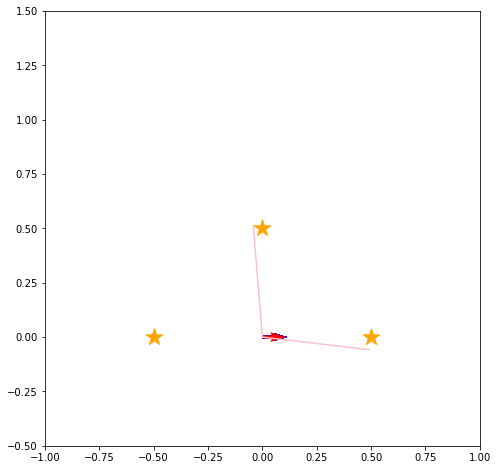

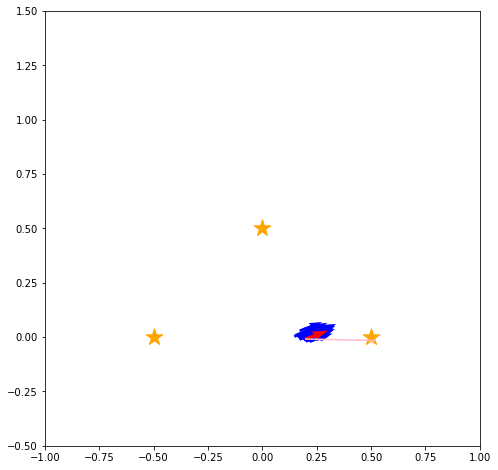

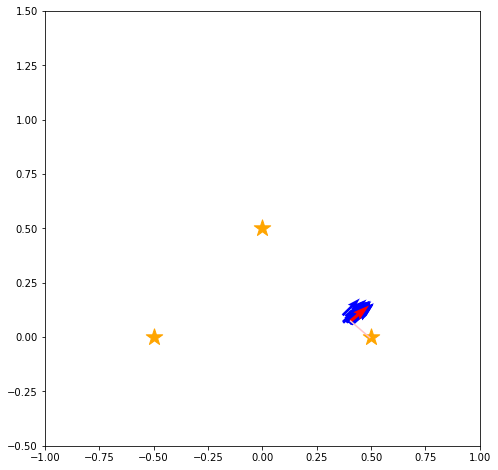

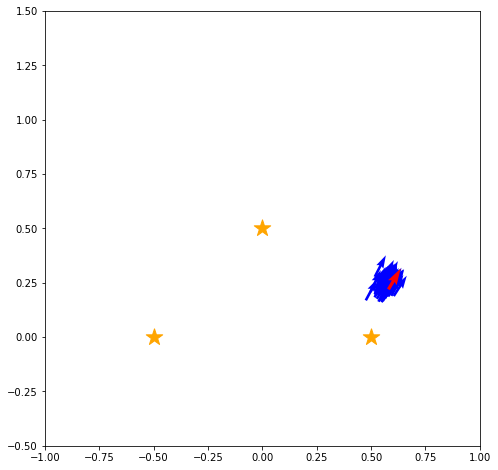

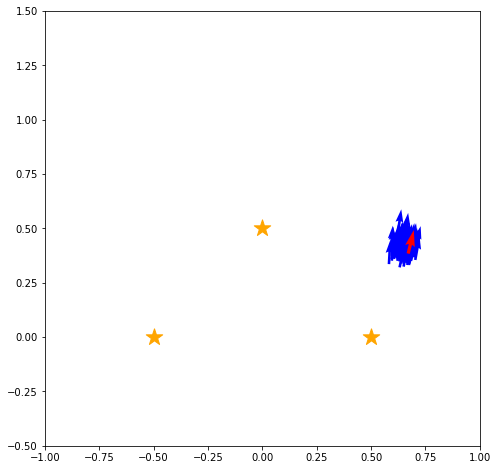

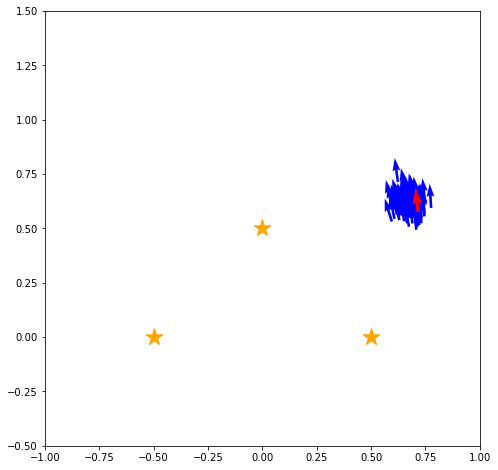

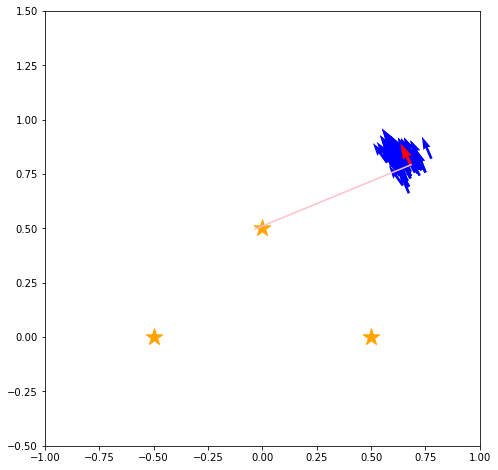

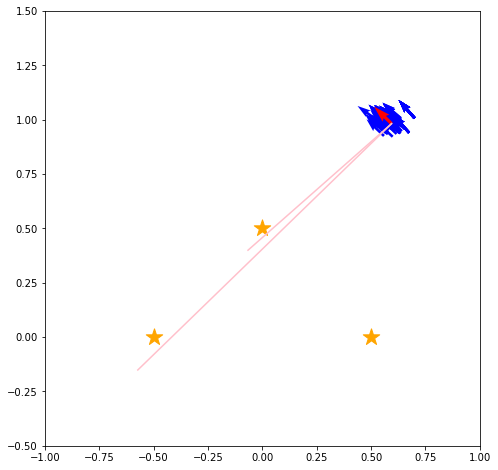

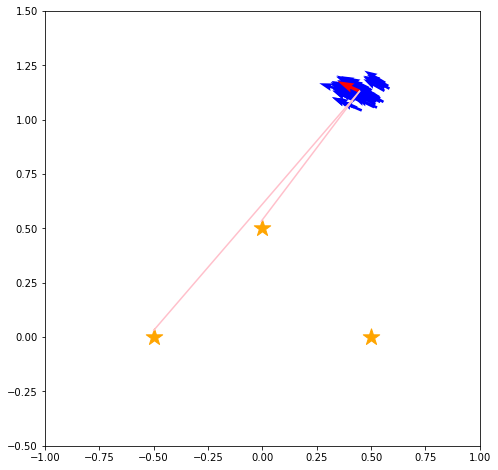

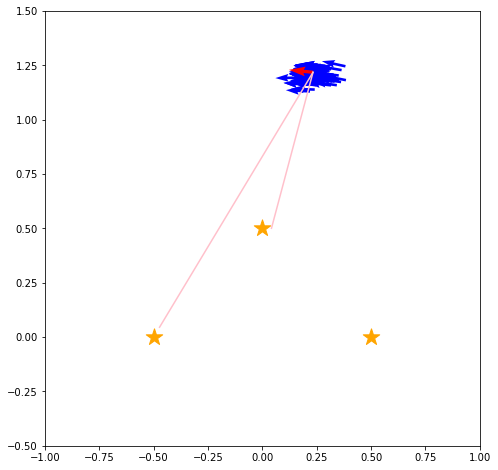

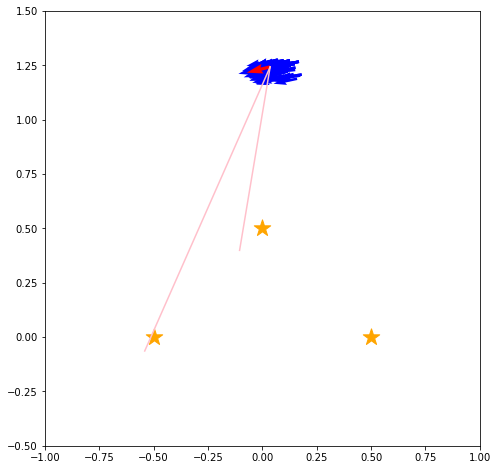

In [19]:
# 設定
actual_x = np.array([0.0, 0.0, 0.0])
actual_landmarks = [[-0.5, 0.0], [0.5, 0.0], [0.0, 0.5]]
particles = [Particle(actual_x, 1.0 / 100) for i in range(100)]
u = np.array([0.2, math.pi / 180 * 20.0])
# ロボットとパーティクル、観測のパス
path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observe_landmarks(actual_x, actual_landmarks)]

for i in range(50):
    actual_x = transition_state(actual_x, u)
    path.append(actual_x)

    # motion update
    update_particles_by_motion(particles, u)

    measurements = observe_landmarks(actual_x, actual_landmarks)
    measurementss.append(measurements)
    # sensor update
    update_particles_by_sensor(particles, measurements)
    
    # resampling
    particles = resample_particles(particles)
    particle_path.append(copy.deepcopy(particles))


for i,p in enumerate(path):
    draw_robot_and_particles(path[i], particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i], measurementss[i])